# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

The goals / steps of this project are the following:
* Load the data set (see below for links to the project data set)
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images
* Summarize the results with a written report

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_un, y_train = train['features'], train['labels']
X_valid_un, y_valid = valid['features'], valid['labels']
X_test_un, y_test = test['features'], test['labels']

assert(len(X_train_un) == len(y_train))
assert(len(X_valid_un) == len(y_valid))
assert(len(X_test_un) == len(y_test))

print()
print("Image Shape: {}".format(X_train_un[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train_un)))
print("Validation Set: {} samples".format(len(X_valid_un)))
print("Test Set:       {} samples".format(len(X_test_un)))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

The following code block provides details about the training, validation and test dataset sizes and the number of classes. This gives us a better idea as to whether the validation set has enough number of samples. Also, are there enough samples to train the deep neural network since a smaller dataset size might overfit the network.

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

from collections import Counter
# TODO: Number of training examples
n_train = len(X_train_un)

# TODO: Number of validation examples
n_validation = len(X_valid_un)

# TODO: Number of testing examples.
n_test = len(X_test_un)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train_un[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Here I visualize the German Traffic Signs Dataset using the pickled file(s). I have plotted randomly chosed 20 images here just to understand what would be the particular issues that would be required to be addressed. Here we can see that few of the images are dark. This can be corrected using histogram equalization. This basically broadens the range in which the color values are distributed. This helps the image brighten a bit since it distributes the intensity values.

I also provide a count of the different classes in the dataset. The distribution of the classes is important since the weight updates will be biased towards the class that is more frequent than the class that doesn't appear as much. This will cause the accuracy to drop for the poorly represented class. This problem can be solved by augmenting the examples of classes that are not well represented.

The bar graph below provides a visual respresentation of the various number of examples of a particular class in the dataset

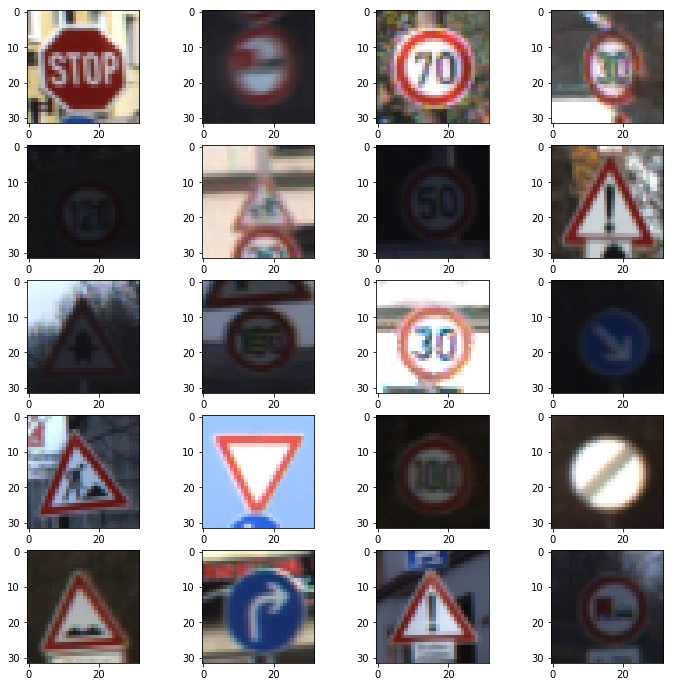

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f, axarr = plt.subplots(5,4, figsize=(12, 12))
for i in range(20):
    index = random.randint(0, len(X_train_un))
    image = X_train_un[index].squeeze()
    axarr[i // 4 , i % 4].imshow(image)
    


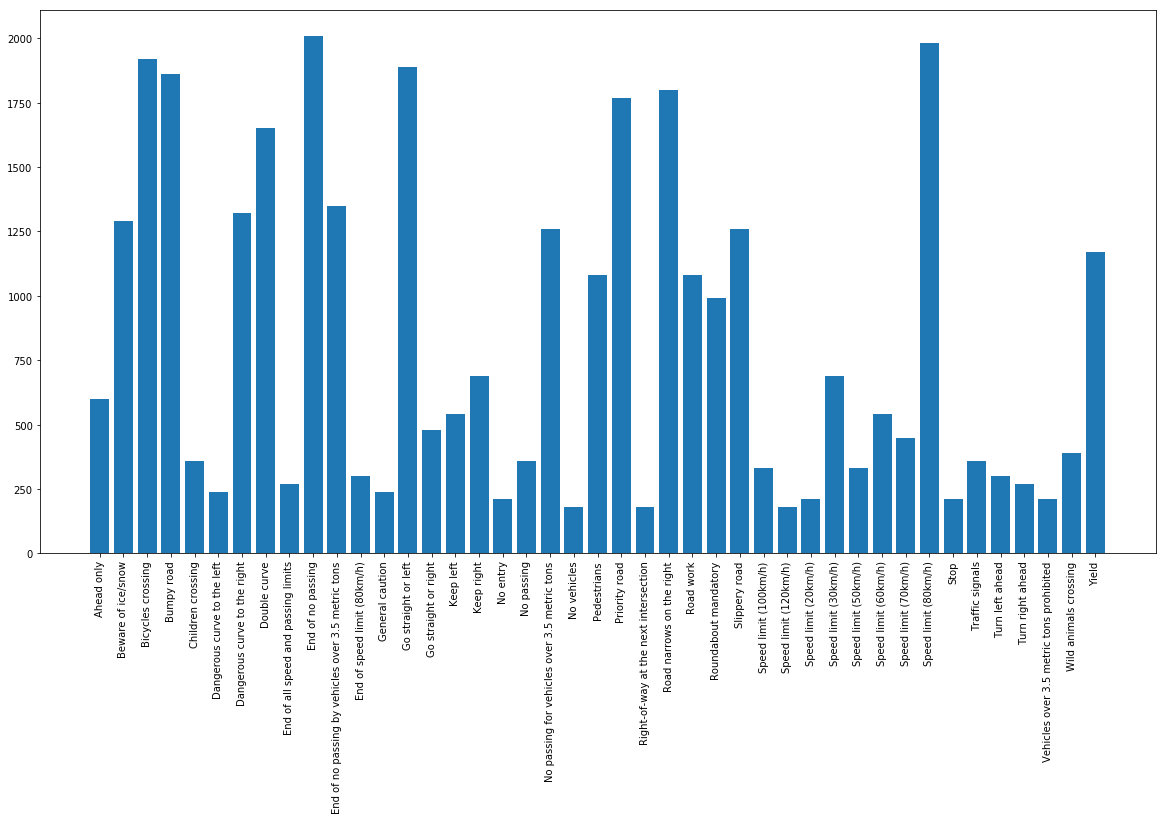

In [5]:
import pandas as pd
df = pd.read_csv('signnames.csv')
counter = Counter(y_train)
plt.figure(figsize=(20,10))
plt.bar(df.values[:,1], counter.values(), align='center')
plt.xticks(rotation=90)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Designed and implemented a deep learning model that learns to recognize traffic signs. Trained and tested my model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The architecture skeleton is that of LeNet-5, though there are many regularization layers that are added in order to prevent overfitting and maintain validation accuracy.

Batch Normalization: It is well known that the inputs to the activation function should form a standard normal distribution to aid in faster learning. We can learn faster since the activation neurons are not saturated.

### Pre-process the Data Set (normalization, grayscale, etc.)

Here I perform histogram equalization of the images so that the range of intensity values is distributed over the entire range of 0 to 255, better.

The image data is also normalized so that the data has mean zero and equal variance. The image data is approximately normalized using `(pixel - 128)/ 128`.

I also convert the images to grayscale here. It empirically worked better.


In [6]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
import tensorflow as tf
import cv2

X_train_un = [cv2.cvtColor(X_train_un[i], cv2.COLOR_RGB2GRAY) for i in range(len(X_train_un))]
X_valid_un = [cv2.cvtColor(X_valid_un[i], cv2.COLOR_RGB2GRAY) for i in range(len(X_valid_un))]
X_test_un = [cv2.cvtColor(X_test_un[i, :, :, :], cv2.COLOR_RGB2GRAY) for i in range(len(X_test_un))]

In [7]:
# print(X_test_un[0].shape)

X_train_un = [(X_train_un[i] - np.min(np.array(X_train_un[i]))) / (np.max(np.array(X_train_un[i]))
                                                                   - np.min(np.array(X_train_un[i])))
              for i in range(len(X_train_un))]
X_valid_un = [(X_valid_un[i] - np.min(np.array(X_valid_un[i]))) / (np.max(np.array(X_valid_un[i]))
                                                                   - np.min(np.array(X_valid_un[i])))
              for i in range(len(X_valid_un))]
X_test_un = [(X_test_un[i] - np.min(np.array(X_test_un[i]))) / (np.max(np.array(X_test_un[i]))
                                                                - np.min(np.array(X_test_un[i]))) 
             for i in range(len(X_test_un))]

# print(np.max(X_train_un[0]))

In [8]:
X_train_un = np.array(X_train_un) * 255.0
X_valid_un = np.array(X_valid_un) * 255.0
X_test_un = np.array(X_test_un) * 255.0

# print(np.max(X_train_un[0]))

In [9]:
X_train_nm = [(np.array(X_train_un[i]) - 128) / 128 for i in range(len(X_train_un))]
X_valid_nm = [(np.array(X_valid_un[i]) - 128) / 128 for i in range(len(X_valid_un))]
X_test_nm = [(np.array(X_test_un[i]) - 128) / 128 for i in range(len(X_test_un))]

X_train_nm = np.expand_dims(np.array(X_train_nm), axis=3)
X_valid_nm = np.expand_dims(np.array(X_valid_nm), axis=3)
X_test_nm = np.expand_dims(np.array(X_test_nm), axis=3)

print("train_max:", np.max(X_train_nm))
print("valid_max:", np.max(X_valid_nm))
print("test_max:", np.max(X_test_nm))

# print(X_test_nm.shape)

train_max: 0.9921875
valid_max: 0.9921875
test_max: 0.9921875


In [10]:
X_train = X_train_nm - np.expand_dims(X_train_nm.mean(axis=0), axis=0)
X_valid = X_valid_nm - np.expand_dims(X_valid_nm.mean(axis=0), axis=0)
X_test = X_test_nm - np.expand_dims(X_test_nm.mean(axis=0), axis=0)

# X_test.shape

### Model Architecture

The base architecture used is LeNet which is the Convolutional Neural Network model that was proposed by Yan LeCunn in 1998. Even though the base architecture which includes the conv and maxpool layers is the same, I have added many regularization layers for faster training and better validation accuracy.

In addition to this the following concepts are used appropriated in the model:

* Batch Normalization
* Dropout

Batch normalization basically tries to achieve mean centering and unit variance of inputs to the activations so that the neurons aren't saturated and this enables faster training.

The concept of dropout is more on the lines of an ensemble of classifiers achieved by randomly deactivating neurons with a given probability. Here the probability is fixed to 0.5, but we can also progressively increase the probability as the number of parameters of the model increases with the depth of the model.

The base architecture looks like the following:

[image1]: ./LeNet.png "Visualization"

![alt text][image1]




In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

def maxpool2d(x, k=2, strides=2, padding='VALID'):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, strides, strides, 1],
        padding=padding)

def conv2d(x, W, b, strides=1, padding='VALID'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Store layers weight & bias
    weights = {
    'wc1': tf.Variable(tf.contrib.layers.xavier_initializer_conv2d()([5, 5, 1, 6])),
    'wc2': tf.Variable(tf.contrib.layers.xavier_initializer_conv2d()([5, 5, 6, 16])),
    'wd1': tf.Variable(tf.contrib.layers.xavier_initializer()([400, 120])),
    'wd2': tf.Variable(tf.contrib.layers.xavier_initializer()([120, 84])),
    'out': tf.Variable(tf.contrib.layers.xavier_initializer()([84, n_classes]))}

    biases = {
    'bc1': tf.Variable(tf.zeros([6], tf.float32)),
    'bc2': tf.Variable(tf.zeros([16], tf.float32)),
    'bd1': tf.Variable(tf.zeros([120], tf.float32)),
    'bd2': tf.Variable(tf.zeros([84], tf.float32)),
    'out': tf.Variable(tf.zeros([n_classes], tf.float32))}

    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    


    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    
    conv1 = tf.layers.batch_normalization(conv1,
                                   axis=3, 
                                    momentum=0.99, 
                                    epsilon=0.001, 
                                    center=True, 
                                    scale=True, 
                                    beta_initializer=tf.zeros_initializer(),
                                    gamma_initializer=tf.ones_initializer(),
                                    moving_mean_initializer=tf.zeros_initializer(),
                                    moving_variance_initializer=tf.ones_initializer(),
                                    beta_regularizer=None, 
                                    gamma_regularizer=None)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    maxpoo11 = maxpool2d(conv1)

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(maxpoo11, weights['wc2']  / 2, biases['bc2'])
    

    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    
    conv2 = tf.layers.batch_normalization(conv2,
                           axis=3, 
                            momentum=0.99, 
                            epsilon=0.001, 
                            center=True, 
                            scale=True, 
                            beta_initializer=tf.zeros_initializer(),
                            gamma_initializer=tf.ones_initializer(),
                            moving_mean_initializer=tf.zeros_initializer(),
                            moving_variance_initializer=tf.ones_initializer(),
                            beta_regularizer=None, 
                            gamma_regularizer=None)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    maxpool2 = maxpool2d(conv2)

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(maxpool2)

    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(fc1, weights['wd1'] / 2), biases['bd1'])
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    

    
    fc1 = tf.layers.batch_normalization(fc1,
                       axis=1, 
                        momentum=0.99, 
                        epsilon=0.001, 
                        center=True, 
                        scale=True, 
                        beta_initializer=tf.zeros_initializer(),
                        gamma_initializer=tf.ones_initializer(),
                        moving_mean_initializer=tf.zeros_initializer(),
                        moving_variance_initializer=tf.ones_initializer(),
                        beta_regularizer=None, 
                        gamma_regularizer=None)

    # TODO: Dropout.
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2'] / 2), biases['bd2'])
    
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    
    fc2 = tf.layers.batch_normalization(fc2,
                       axis=1, 
                        momentum=0.99, 
                        epsilon=0.001, 
                        center=True, 
                        scale=True, 
                        beta_initializer=tf.zeros_initializer(),
                        gamma_initializer=tf.ones_initializer(),
                        moving_mean_initializer=tf.zeros_initializer(),
                        moving_variance_initializer=tf.ones_initializer(),
                        beta_regularizer=None, 
                        gamma_regularizer=None)

    # TODO: Dropout.
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out'] / 2), biases['out'])
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

As we can see we get an accuracy of 96 - 97 % just on the first 100 epochs.

We can better this by data augmentation and getting a better distribution of the various classes, but I am not doing that here at preset. I will add that later to the project.

The hyperparams used are:
* Number of Epochs
* Batch size
* Learning rate

The number of epochs need not be too high in this case since the model size is small (Just two conv, two maxpool and two fully connected layers). Therefore it is set to 100.

The batch size usually doesn't play a huge part in training. A good balance is struck when the batch size is small enough to avoid some of the poor local minima, but large enough that it doesn't avoid the global minima or better-performing local minima. It is usually set to 128 or 256 for moderate or large sized datasets depeding on the amount of RAM available, since the gradients of the entire neural network for the entire batch is saved in RAM for computing the weight update.

Learning rate is probably the most important hyperparameter that is set empirically.

The optimizer used is 'Adam'. This optimizer maintains a moving average of previous first and second moments which is used to decay the learning rate over time (number of epochs). (This can be thought of a momentum term and acceleration term to the weight update)

In [12]:
# Specify hyperparams
# Setup the feedforward and backprop pipeline

EPOCHS = 100
BATCH_SIZE = 128
rate = 0.002

In [13]:
# Defining the evaluate function

def evaluate(X_data, y_data, logits):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [14]:
### Train your model here...
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
    
# Ensures that we execute the update_ops before performing the train_step
prob = 0.5
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

keep_prob = tf.placeholder_with_default(1.0, shape=())

one_hot_y = tf.one_hot(y, n_classes)
logits = LeNet(x)
saver = tf.train.Saver()

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
# optimizer = tf.train.MomentumOptimizer(learning_rate = rate,
#     momentum=0.9,
#     use_nesterov=False)
optimizer = tf.train.AdamOptimizer(
    learning_rate=rate,
    beta1=0.9,
    beta2=0.99,
    epsilon=1e-08,
    use_locking=False,
    name='Adam'
)
train_op = optimizer.minimize(loss_operation)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

In [12]:
with tf.Session() as sess, tf.control_dependencies(update_ops):
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # saver.restore(sess, tf.train.latest_checkpoint('.'))
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(train_op, feed_dict={x: batch_x, y: batch_y, keep_prob: prob})
            
        validation_accuracy = evaluate(X_valid, y_valid, logits)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.650

EPOCH 2 ...
Validation Accuracy = 0.801

EPOCH 3 ...
Validation Accuracy = 0.866

EPOCH 4 ...
Validation Accuracy = 0.895

EPOCH 5 ...
Validation Accuracy = 0.910

EPOCH 6 ...
Validation Accuracy = 0.911

EPOCH 7 ...
Validation Accuracy = 0.931

EPOCH 8 ...
Validation Accuracy = 0.935

EPOCH 9 ...
Validation Accuracy = 0.943

EPOCH 10 ...
Validation Accuracy = 0.946

EPOCH 11 ...
Validation Accuracy = 0.946

EPOCH 12 ...
Validation Accuracy = 0.941

EPOCH 13 ...
Validation Accuracy = 0.946

EPOCH 14 ...
Validation Accuracy = 0.941

EPOCH 15 ...
Validation Accuracy = 0.949

EPOCH 16 ...
Validation Accuracy = 0.948

EPOCH 17 ...
Validation Accuracy = 0.954

EPOCH 18 ...
Validation Accuracy = 0.951

EPOCH 19 ...
Validation Accuracy = 0.953

EPOCH 20 ...
Validation Accuracy = 0.958

EPOCH 21 ...
Validation Accuracy = 0.951

EPOCH 22 ...
Validation Accuracy = 0.948

EPOCH 23 ...
Validation Accuracy = 0.956

EPOCH 24 ...
Validation Accura

In [23]:
### Test the model

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test, logits)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.937


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

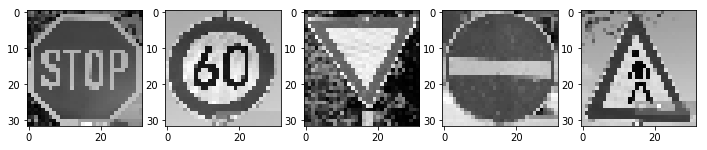

In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import os
import cv2
import matplotlib.gridspec as gridspec

def process_newimage_file(name):
    image = cv2.imread(name)
    image = cv2.resize(image,(32,32))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image/255.
    return image

def plot_newImage_3C(n_row, X):
    f2, axarr2 = plt.subplots(1, n_row, figsize=(12, 12))
    for i in range(n_row):
        image = X[i].squeeze()
        axarr2[i].imshow(image, cmap='gray')
    
newdata_un = [process_newimage_file("./new_images/"+name) for name in os.listdir("./new_images/")]
namenewdata = [name for name in os.listdir("./new_images/")]
newdata_un = np.array(newdata_un ,dtype = np.float32)

newdata_un = [cv2.cvtColor(newdata_un[i], cv2.COLOR_RGB2GRAY) for i in range(len(newdata_un))]
newdata_un = [(newdata_un[i] - np.min(np.array(newdata_un[i]))) / (np.max(np.array(newdata_un[i]))
                                                                   - np.min(np.array(newdata_un[i])))
              for i in range(len(newdata_un))]

newdata_un = np.array(newdata_un) * 255.0
newdata = [(np.array(newdata_un[i]) - 128) / 128 for i in range(len(newdata_un))]

plot_newImage_3C(5,newdata)

newdata = np.expand_dims(np.array(newdata), axis=3)

### Analyze Performance

I get 100 percent accuracy on the images downloaded from the internet

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    feed_dict_new = {x:newdata, keep_prob: 1}
    top5 = tf.nn.top_k(logits, 5)

    top5_pred = sess.run([logits, top5], feed_dict=feed_dict_new)

INFO:tensorflow:Restoring parameters from ./lenet


### Predict the Sign Type for Each Image and output Top 5 Softmax Probabilities For Each Image Found on the Web

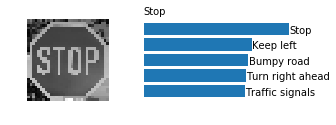

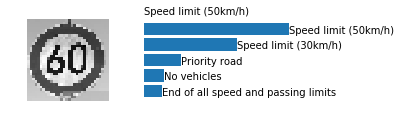

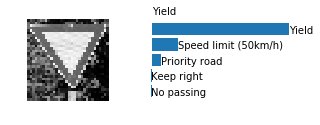

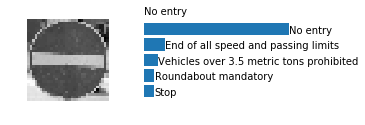

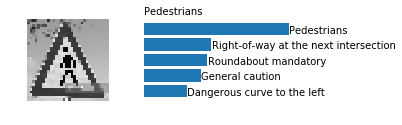

In [21]:
for i in range(5):
    plt.figure(figsize = (5,1.5))
    gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])
    plt.subplot(gs[0])
    plt.imshow(newdata.squeeze()[i], cmap='gray')
    plt.axis('off')
    plt.subplot(gs[1])
    plt.barh(6-np.arange(5),top5_pred[1][0][i], align='center')
    for i_label in range(5):
        plt.text(top5_pred[1][0][i][i_label]+.02,6-i_label-.25,
            df['SignName'][top5_pred[1][1][i][i_label]])
    plt.axis('off')
    plt.text(0, 6.95, df.values[:,1][np.argmax(top5_pred[0][i], 0)])
#     plt.text(0,6.95,namenewdata[i].split('.')[0])
    plt.show();

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [22]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")